# initial setup
* Uses a google account's google drive to store dataset
* prerequisites : a folder named "AI" in the root directory of drive which will be used for dataset.

In [1]:
from google.colab import drive
import os

drive.mount('/content/drive', force_remount=True)
os.chdir("drive/My Drive/Black")

Mounted at /content/drive


# Loading the dataset - 
* Downloads the face mask dataset to your drive and unzips it using drive REST Api.
* Loads the images and its labels to a pandas dataframe
* Save the dataframe as a  pickle file, which can be subsequently used training the model.
* ref : https://colab.research.google.com/notebooks/io.ipynb#scrollTo=u22w3BFiOveA

In [2]:
  """
Preparing the pickle
"""

from pathlib import Path

import pandas as pd
from google_drive_downloader import GoogleDriveDownloader as gdd
from google.colab import drive
from tqdm import tqdm
from pathlib import Path
import shutil

dirpath = Path('data/dataset')
# cleaing tree
if dirpath.exists() and dirpath.is_dir():
    shutil.rmtree(dirpath)

os.makedirs('data/dataset')
datasetPath = Path('data/dataset/black.zip')
gdd.download_file_from_google_drive(file_id='1H7AVjsqI0r9dVDn-J_BMWEWIJdW_viEe',dest_path=str(datasetPath),unzip=True)

# https://drive.google.com/file/d/1H7AVjsqI0r9dVDn-J_BMWEWIJdW_viEe/view?usp=sharing

datasetPath.unlink()
datasetPath = Path('data/dataset')
clothMaskPath = datasetPath/'with_cloth_mask'
surgicalMaskPath = datasetPath/'with_surgical_mask'
ffp2MaskPath = datasetPath/'with_ffp2_mask'
nonMaskPath = datasetPath/'without_mask'

maskDF = pd.DataFrame()
for imgPath in tqdm(list(nonMaskPath.iterdir()), desc='without_mask'):
    maskDF = maskDF.append({
        'image': str(imgPath),
        'mask': 0
    }, ignore_index=True)

for imgPath in tqdm(list(surgicalMaskPath.iterdir()), desc='with_surgical_mask'):
    maskDF = maskDF.append({
        'image': str(imgPath),
        'mask': 1
    }, ignore_index=True)

for imgPath in tqdm(list(clothMaskPath.iterdir()), desc='with_cloth_mask'):
    maskDF = maskDF.append({
        'image': str(imgPath),
        'mask': 2
    }, ignore_index=True)

for imgPath in tqdm(list(ffp2MaskPath.iterdir()), desc='with_ffp2_mask'):
    maskDF = maskDF.append({
        'image': str(imgPath),
        'mask': 3
    }, ignore_index=True)

print(maskDF)

dfName = 'data/dataset/dataset.pickle'
print(f'Saving Dataframe to: {dfName}')
maskDF.to_pickle(dfName)

Unzipping...Done.


with_ffp2_mask: 100%|██████████| 200/200 [00:00<00:00, 223.43it/s]

                                                 image  mask
0       data/dataset/without_mask/without_mask (1).jpg   0.0
1      data/dataset/without_mask/without_mask (10).jpg   0.0
2     data/dataset/without_mask/without_mask (100).jpg   0.0
3     data/dataset/without_mask/without_mask (101).jpg   0.0
4     data/dataset/without_mask/without_mask (102).jpg   0.0
..                                                 ...   ...
795  data/dataset/with_ffp2_mask/27_1_1_20170117010...   3.0
796  data/dataset/with_ffp2_mask/27_1_1_20170117010...   3.0
797  data/dataset/with_ffp2_mask/27_1_1_20170117010...   3.0
798  data/dataset/with_ffp2_mask/27_1_1_20170117010...   3.0
799  data/dataset/with_ffp2_mask/27_1_1_20170117010...   3.0

[800 rows x 2 columns]
Saving Dataframe to: data/dataset/dataset.pickle


# Custom dataset class
* Loads the dataset as PIL
* Resizes images to 32x32
* Convert image to tensor -https://discuss.pytorch.org/t/pytorch-pil-to-tensor-and-vice-versa/6312
* Normalizes images to have values in the range of 0-1

In [3]:
"""
The DataSet class
"""

from PIL import Image
import numpy as np
from torch import long, tensor
from torch.utils.data.dataset import Dataset
from torchvision.transforms import Compose, Resize, ToTensor, Normalize


class MaskDetectionDataset(Dataset):
    def __init__(self, dataFrame):
        self.dataFrame = dataFrame
        # mean=[0.485, 0.456, 0.406],
        # std=[0.229, 0.224, 0.225],
        self.transformations = Compose([
            Resize((32, 32)),
            ToTensor(),
            Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]
                )
        ])
    
    def __getitem__(self, key):
        if isinstance(key, slice):
            raise NotImplementedError('slicing is not supported')
        
        row = self.dataFrame.iloc[key]
        image = Image.open(row['image']).convert('RGB')
        return {
          'image': self.transformations(image),
          'mask': tensor([row['mask']], dtype=long),
          'path': row['image']
        }
    
    def __len__(self):
        return len(self.dataFrame.index)

# CNN model for face mask detection
* The model takes 3 channels(R,G,B) as input
* The model gives an output of one of 4 classes 
* 0 -> without_mask, 1 -> 'with_mask_surgical', 2 -> 'with_mask_cloth', 3 -> 'with_mask_ffp2'

In [4]:
"""
The CNN model
"""

import torch
import torch.nn.init as init
import torch.nn as nn
from torch import Tensor
from torch.nn import (Conv2d, CrossEntropyLoss, Linear, MaxPool2d, ReLU, Sequential, functional, LeakyReLU, BatchNorm2d)

class FaceMaskDetectorCNN(nn.Module):
    def __init__(self):
        # super(FaceMaskDetectorCNN, self).__init__()
        # # Conv Layers : Conv2d
        # self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1) # 32 - 3 + 1 + 2*1 ->  32   -> 16 from forward pass
        # self.conv2 = nn.Conv2d(in_channels=16, out_channels=8, kernel_size=3, padding=1) # 32 - 3 + 1 + 2*1 -> 32  -> 8 from forward pass
        # #fully Connected: Linear :: features
        # # torch.nn.Linear(in_features, out_features, bias=True)
        # # in_features – size of each input sample
        # # out_features – size of each output sample
        # batch_size = 3
        # # Simulate a 32 x 32 pixel, rgb "image"
        # ip = torch.randn(3, 32, 32)
        # print(ip.view(batch_size, -1).size())
        # self.fc1 = nn.Linear(8 * 8 * 8, 32)  # 8(out_channel :: prev) &&  8 * 8(computation from the forward max_pool2d * 2 with stride 2) 
        # self.fc2 = nn.Linear(32, 4) # final feature labels as 4
    

        super(FaceMaskDetectorCNN, self).__init__()
        self.conv_layer = nn.Sequential(
          nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1), # input layer RGB    32  
          nn.BatchNorm2d(32),
          nn.LeakyReLU(inplace=True),
          nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),# feature specific   32
          nn.BatchNorm2d(32),
          nn.LeakyReLU(inplace=True),
          nn.MaxPool2d(kernel_size=2, stride=2),
          nn.Conv2d(in_channels=32, out_channels=128, kernel_size=3, padding=1), # 16 * 16
          nn.BatchNorm2d(128),
          nn.LeakyReLU(inplace=True),
          nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1), #16
          nn.BatchNorm2d(64),
          nn.LeakyReLU(inplace=True),
          nn.MaxPool2d(kernel_size=2, stride=2),  # 8 * 8
        )
        self.fc_layer = nn.Sequential(
          nn.Dropout(p=0.1),
          nn.Linear(8 * 8 * 64, 1000),  # Fully connected (input (l*b*channels) , output features) How 
          nn.ReLU(inplace=True),
          nn.Linear(1000, 512), 
          nn.ReLU(inplace=True),
          nn.Dropout(p=0.1),
          nn.Linear(512, 4)  
        )

    def forward(self, x: Tensor):
        """ forward pass 
        The forward() method is the actual network transformation. 
        The forward method is the mapping that maps an input tensor 
        to a prediction output tensor.
        # Convolution Operation
        """
        # out = functional.max_pool2d(torch.tanh(self.conv1(x)), 2) # 32 -> 16
        # out = functional.relu(out)
        # out = functional.max_pool2d(torch.tanh(self.conv2(out)), 2) # 16 -> 8
        # out = functional.relu(out)
        # flatten
        # out = out.view(-1, 8 * 8 * 8)
        # out = torch.tanh(self.fc1(out))
        # # fc layer
        # out = self.fc2(out)

        # conv layers
        x = self.conv_layer(x)
        # flatten
        x = x.view(x.size(0), -1) # reshapes into one dimensional object
        # fc layer
        x = self.fc_layer(x)
        return x

face_mask_detector_cnn = FaceMaskDetectorCNN()
print(face_mask_detector_cnn)

FaceMaskDetectorCNN(
  (conv_layer): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01, inplace=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01, inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(32, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): LeakyReLU(negative_slope=0.01, inplace=True)
    (10): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): LeakyReLU(negative_slope=0.01, inpl

# Summary of Layers

In [5]:
"""
Print model summary
"""

from torchsummary import summary
print(summary(face_mask_detector_cnn,input_size=(3,32,32)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
       BatchNorm2d-2           [-1, 32, 32, 32]              64
         LeakyReLU-3           [-1, 32, 32, 32]               0
            Conv2d-4           [-1, 32, 32, 32]           9,248
       BatchNorm2d-5           [-1, 32, 32, 32]              64
         LeakyReLU-6           [-1, 32, 32, 32]               0
         MaxPool2d-7           [-1, 32, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]          36,992
       BatchNorm2d-9          [-1, 128, 16, 16]             256
        LeakyReLU-10          [-1, 128, 16, 16]               0
           Conv2d-11           [-1, 64, 16, 16]          73,792
      BatchNorm2d-12           [-1, 64, 16, 16]             128
        LeakyReLU-13           [-1, 64, 16, 16]               0
        MaxPool2d-14             [-1, 6

# Data Split

* Loads the pickle file that was saved previously
* Splits dataset into 70/30 split for test,validate
* Create a DataLoader helper function for automatic batching

In [6]:
"""
Some utilities
"""

from pathlib import Path
from typing import Dict, List, Union

import pandas as pd
import torch
import torch.nn.init as init
from sklearn.model_selection import train_test_split
from torch import Tensor
from torch.nn import (Conv2d, CrossEntropyLoss, Linear, MaxPool2d, ReLU, Sequential)
from torch.optim import Adam
from torch.optim.optimizer import Optimizer
from torch.utils.data import DataLoader
import itertools
import matplotlib.pyplot as plt

def plot_cm(cm, classes, normalize=False, title='Visualization of the confusion matrix', cmap=plt.cm.Reds):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Actual True label')
    plt.xlabel('Predicted label')

def prepare_data(mask_df_path) -> None:
        mask_df = pd.read_pickle(mask_df_path)
        # print the distribution
        print(mask_df['mask'].value_counts())
        # train: 1646  :: test: 706
        train, validate = train_test_split(mask_df, test_size=0.3, random_state=0,
                                           stratify=mask_df['mask'])
        return [
            MaskDetectionDataset(train),
            MaskDetectionDataset(validate),
            CrossEntropyLoss()
            ]

def train_dataloader(train_df) -> DataLoader:
    return DataLoader(train_df, batch_size=32, shuffle=True, num_workers=4)

def val_dataloader(validate_df) -> DataLoader:
    return DataLoader(validate_df, batch_size=32, num_workers=4)   

train_df, validate_df, cross_entropy_loss = prepare_data("data/dataset/dataset.pickle")

3.0    200
2.0    200
1.0    200
0.0    200
Name: mask, dtype: int64


# Training the model
* For each batch get the images and its labels
* Pass it to the model to get predictions
* compare losses with actual, predicted values

In [7]:
print(train_df.dataFrame)
print(train_dataloader(train_df))

                                                 image  mask
704  data/dataset/with_ffp2_mask/26_1_1_20170116232...   3.0
5     data/dataset/without_mask/without_mask (103).jpg   0.0
569  data/dataset/with_cloth_mask/24_1_1_2017011220...   2.0
625  data/dataset/with_ffp2_mask/26_1_1_20170116175...   3.0
380  data/dataset/with_surgical_mask/26_1_1_2017011...   1.0
..                                                 ...   ...
18    data/dataset/without_mask/without_mask (115).jpg   0.0
467  data/dataset/with_cloth_mask/21_1_1_2017011719...   2.0
201  data/dataset/with_surgical_mask/26_1_1_2017011...   1.0
171    data/dataset/without_mask/without_mask (73).jpg   0.0
195    data/dataset/without_mask/without_mask (95).jpg   0.0

[560 rows x 2 columns]


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [8]:
from torch.utils.data import DataLoader
from torchvision import transforms
from sklearn.model_selection import KFold
import os
import torch
from torch import nn

epochs = 10 
learning_rate = 0.001 
retrain = False
"""
Training Step
~ adaptive moment estimation.
Adam as an optimizer, just adds expected value of the past gradient.
So, it can take different size steps for different params.
and add momentum for every parameter it can perform optimum.

updates network weights iterative based in training data.

Stochastic gradient descent maintains a single learning rate (termed alpha) for all weight updates and the learning rate does not change during training.
A learning rate is maintained for each network weight (parameter) and separately adapted as learning unfolds.
ref: https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/
"""

import warnings
warnings.filterwarnings('ignore')


def train_model():
    optimizer = Adam(face_mask_detector_cnn.parameters(), lr=learning_rate)
    for epoch in range(epochs):
        loss_train = 0.0
        for i, data in enumerate(train_dataloader(train_df), 0):
            inputs, labels = data['image'], data['mask']
            labels = labels.flatten()
            outputs = face_mask_detector_cnn(inputs)
            loss = cross_entropy_loss(outputs, labels)
            optimizer.zero_grad() 
            loss.backward()
            optimizer.step()
            loss_train += loss
        print(f' LOSS :: Training Loss (after epoch {epoch}):', loss_train)
        

train_model()
print('Model training has finished')

 LOSS :: Training Loss (after epoch 0): tensor(30.9089, grad_fn=<AddBackward0>)
 LOSS :: Training Loss (after epoch 1): tensor(24.4932, grad_fn=<AddBackward0>)
 LOSS :: Training Loss (after epoch 2): tensor(21.2013, grad_fn=<AddBackward0>)
 LOSS :: Training Loss (after epoch 3): tensor(16.4554, grad_fn=<AddBackward0>)
 LOSS :: Training Loss (after epoch 4): tensor(13.6091, grad_fn=<AddBackward0>)
 LOSS :: Training Loss (after epoch 5): tensor(10.4778, grad_fn=<AddBackward0>)
 LOSS :: Training Loss (after epoch 6): tensor(8.7969, grad_fn=<AddBackward0>)
 LOSS :: Training Loss (after epoch 7): tensor(8.9076, grad_fn=<AddBackward0>)
 LOSS :: Training Loss (after epoch 8): tensor(6.7529, grad_fn=<AddBackward0>)
 LOSS :: Training Loss (after epoch 9): tensor(6.1229, grad_fn=<AddBackward0>)
Model training has finished


# Evaluate the model 
* Run the model to evaluate its accuracy on unseen images using validate dataset
* print model's accuracy, f1, precision, recall scores

                                                 image  mask
140    data/dataset/without_mask/without_mask (45).jpg   0.0
105   data/dataset/without_mask/without_mask (194).jpg   0.0
755  data/dataset/with_ffp2_mask/27_1_1_20170112193...   3.0
715  data/dataset/with_ffp2_mask/26_1_1_20170116234...   3.0
753  data/dataset/with_ffp2_mask/27_1_1_20170109131...   3.0
..                                                 ...   ...
261  data/dataset/with_surgical_mask/26_1_1_2017011...   1.0
253  data/dataset/with_surgical_mask/26_1_1_2017011...   1.0
39    data/dataset/without_mask/without_mask (134).jpg   0.0
374  data/dataset/with_surgical_mask/26_1_1_2017011...   1.0
28    data/dataset/without_mask/without_mask (124).jpg   0.0

[240 rows x 2 columns]
                    precision    recall  f1-score   support

      without_mask     0.8806    0.9833    0.9291        60
with_mask_surgical     0.5227    0.7667    0.6216        60
   with_mask_cloth     0.9574    0.7500    0.8411        60
   

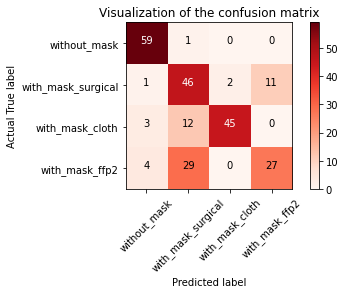

In [9]:
"""
Evaluate the model
"""

from numpy import vstack
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix

def evaluate_model():
    print(validate_df.dataFrame)
    predictions, actuals = torch.tensor([]), torch.tensor([])
    for i, data in enumerate(val_dataloader(validate_df)):
        inputs, targets = data['image'], data['mask']
        targets = targets.flatten()
        output = face_mask_detector_cnn(inputs)
        output = torch.argmax(output,axis=1) #max
        predictions = torch.cat((predictions, output.flatten()), dim=0)
        actuals = torch.cat((actuals, targets), dim=0)  
    classes = ['without_mask','with_mask_surgical', 'with_mask_cloth', 'with_mask_ffp2']
    print(classification_report(actuals, predictions, digits = 4, target_names=classes))
    confusion_mat = confusion_matrix(actuals.numpy(), predictions.numpy())
    plot_cm(confusion_mat, classes)
evaluate_model()

# Prediction of random image using trained Model

data/dataset/with_surgical_mask/26_1_1_20170117153641469_surgical.jpg
Actual: with_mask_surgical
Predicted: with_mask_surgical


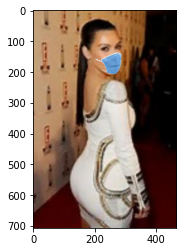

In [16]:
"""
Predict
"""

import matplotlib.pyplot as plt
import random

class_mapping = {
    0: "without_mask",
    1: "with_mask_surgical",
    2: "with_mask_cloth",
    3: "with_mask_ffp2",
}

def predict():
  rand_sampler = torch.utils.data.RandomSampler(validate_df, num_samples=32, replacement=True)
  data = iter(DataLoader(validate_df, batch_size=32, num_workers=1, sampler=rand_sampler)).next()
  inputs,targets = data['image'], data['mask']
  output = face_mask_detector_cnn(inputs)
  output = torch.argmax(output,axis=1)
  rand_ind = random.choice(list(range(0,32)))
  print(data['path'][rand_ind])
  img = Image.open(data['path'][rand_ind])
  plt.imshow(np.asarray(img))
  print("Actual:", class_mapping[targets[rand_ind].tolist()[0]])
  print("Predicted:",class_mapping[output[rand_ind].tolist()])

predict()